In [1]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
from torch_geometric.datasets import MoleculeNet
import matplotlib.pyplot as plt

import torch
import os
import pandas as pd
import numpy as np
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx

from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torch
import torch.nn as nn

import Data_Preprocessing.Graph_Data as gd
from Data_Preprocessing.Graph_Data import Molecule_data
from models.AttentiveFPModel import AttentiveFP
import seaborn as sns





In [2]:
df = pd.read_csv('Data_Preprocessing/omdb_smile_data_set.csv')

In [3]:
smiles = df['SMILE']
codIds = df['CODID']
band_gap = df['bgs']

In [4]:
print(band_gap.mean())
print(band_gap.min())
print(band_gap.max())

3.0630082776213756
0.0
8.54


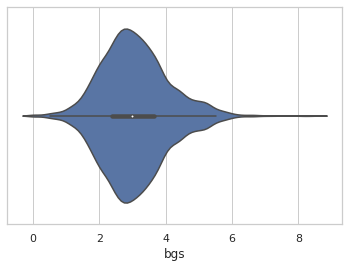

In [5]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.violinplot(x=band_gap)

In [6]:
train_ratio = 0.70
validation_ratio = 0.10
test_ratio = 0.20

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(smiles, band_gap, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


In [7]:
# X_train, X_val, y_train, y_val = train_test_split(smiles, band_gap, test_size=0.2)

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [9]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [10]:
print(len(band_gap))

11368


# Train

In [11]:
smile_graph = {}
band_gap_arr = []
smiles_array = []

for i,smile in tqdm(enumerate(x_train)):
    g = gd.smile_to_graph(smile)
    if g != None:
        smile_graph[smile] = g
        band_gap_arr.append(y_train[i])
        smiles_array.append(smile)

In [12]:
print(len(band_gap_arr))

7330


# Validation

In [13]:
smile_graph_val = {}
band_gap_arr_val = []
smiles_array_val = []
for i,smile in enumerate(x_val):
    g = gd.smile_to_graph(smile)
    if g != None:
        smile_graph_val[smile] = g
        band_gap_arr_val.append(y_val[i])
        smiles_array_val.append(smile)

# Test

In [14]:
smile_graph_test = {}
band_gap_arr_test = []
smiles_array_test = []
for i,smile in enumerate(x_test):
    g = gd.smile_to_graph(smile)
    if g != None:
        smile_graph_test[smile] = g
        band_gap_arr_test.append(y_test[i])
        smiles_array_test.append(smile)

# Train Graph

In [15]:
train_data = Molecule_data(root='data', dataset='train_data_set',y=band_gap_arr,smile_graph=smile_graph,smiles=smiles_array)

# Validation Graph

In [16]:
val_data = Molecule_data(root='data', dataset='val_data_set',y=band_gap_arr_val,smile_graph=smile_graph_val,smiles=smiles_array_val)

# Test Graph

In [17]:
test_data = Molecule_data(root='data', dataset='test_data_set',y=band_gap_arr_test,smile_graph=smile_graph_test,smiles=smiles_array_test)

In [18]:
TRAIN_BATCH_SIZE = 17

In [19]:
train_loder   = DataLoader(train_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
test_loder  = DataLoader(test_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
val_loder  = DataLoader(val_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)

In [20]:
next(iter(train_loder))

Batch(x=[414, 114], edge_index=[2, 884], y=[17], c_size=[17], batch=[414], ptr=[18])

In [21]:
if torch.cuda.is_available():  
    device = "cuda:6"
    print("cuda:6")
else:  
    device = "cpu" 
    print(torch.cuda.is_available())

cuda:6


In [22]:
# training function at each epoch
def train(model, device, train_loader, optimizer, epoch,loss_fn):
    #print('Training on {} samples...'.format(len(train_loader1.dataset)))
    model.train()
    Loss = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x.float(), data.edge_index,data.batch)
        loss = loss_fn(output, data.y.view(-1, 1).float().to(device))
        loss.backward()
        optimizer.step()
        Loss.append(loss.item())
    nploss = np.asarray(Loss)
    avg_loss = np.average(nploss)
    return avg_loss

In [23]:
def predicting(model, device, loader,loss_fn):
    model.eval()
    total_loss=total_example=0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data.x.float(), data.edge_index,data.batch)
            loss = loss_fn(output, data.y.view(-1, 1).float().to(device))
            total_loss+=loss
            total_example+=1
    return total_loss/total_example

In [24]:
model = AttentiveFP(in_channels=114, hidden_channels=292, out_channels=1,
                    num_layers=3, num_timesteps=1,
                    dropout= 0.05115077176824934).to(device)

In [25]:
print(model)

AttentiveFP(
  (lin1): Linear(in_features=114, out_features=292, bias=True)
  (atom_convs): ModuleList(
    (0): GATEConv(
      (lin1): Linear(in_features=292, out_features=292, bias=False)
      (lin2): Linear(in_features=292, out_features=292, bias=False)
    )
    (1): GATConv(292, 292, heads=1)
    (2): GATConv(292, 292, heads=1)
  )
  (atom_grus): ModuleList(
    (0): GRUCell(292, 292)
    (1): GRUCell(292, 292)
    (2): GRUCell(292, 292)
  )
  (mol_conv): GATConv(292, 292, heads=1)
  (mol_gru): GRUCell(292, 292)
  (lin2): Linear(in_features=292, out_features=1, bias=True)
)


In [26]:
#LR = 0.005
LR = 8.28967316828403e-05
eps_rate = 1.7687722582665366e-05
weight_decay = 1.3459636454913954e-06
LOG_INTERVAL = 20
NUM_EPOCHS = 3000
results = []

In [27]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [28]:
#loss_fn = nn.MSELoss()
#loss_fn = RMSELoss()
loss_fn = nn.L1Loss()
model = model.cuda(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer = torch.optim.Adam(model.parameters(),lr=LR,betas=(0.9,0.999),
                                 eps=eps_rate,weight_decay=weight_decay,amsgrad=False)

In [29]:
best_ret = []
best_mse = 0.80
best_ci = 0
patience=0
best_epoch = -1
model_st = "GCNNet"
model_file_name = 'model_New' + model_st  +  '.model'
result_file_name = 'result_' + model_st +  '.csv'

val_losses = []
train_losses = []

the_last_loss = 100
patience = 26
trigger_times = 0
count_loss_difference = 0

for epoch in range(NUM_EPOCHS):
    train_loss=train(model, device, train_loder, optimizer, epoch+1,loss_fn)
    test_loss = predicting(model, device, val_loder,loss_fn)
#     test_loss = predicting(model, device, test_loder,loss_fn)
#     print('Epoch% d: Train mae: %2.5f\t val mae: %2.5f\t test mae: %2.5f\t'
#           %(epoch, train_loss, val_loss.item(),test_loss.item()))

    print('Epoch% d: Train mae: %2.5f\t val mae: %2.5f\t'
          %(epoch, train_loss,test_loss.item()))
    ret = [epoch,train_loss,test_loss.item()]
    
    train_losses.append(train_loss)
    val_losses.append(test_loss.item())
    # Early stopping
    the_current_loss = test_loss.item()
    
    if the_current_loss > the_last_loss:
        trigger_times += 1
        print('trigger times:', trigger_times)

        if trigger_times >= patience:
            print('Early stopping!\nStart to test process.')
            break
    else:
        
        trigger_times = 0
        the_last_loss = the_current_loss
        torch.save(model.state_dict(), 'Graph_attention_best_12.model')


    with open(result_file_name,'w') as f:
        f.write(','.join(map(str,ret)))


Epoch 0: Train mae: 0.89509	 val mae: 0.72090	
Epoch 1: Train mae: 0.64957	 val mae: 0.61069	
Epoch 2: Train mae: 0.59063	 val mae: 0.58404	
Epoch 3: Train mae: 0.56358	 val mae: 0.60024	
trigger times: 1
Epoch 4: Train mae: 0.54563	 val mae: 0.56316	
Epoch 5: Train mae: 0.52325	 val mae: 0.55332	
Epoch 6: Train mae: 0.49525	 val mae: 0.50632	
Epoch 7: Train mae: 0.47205	 val mae: 0.47941	
Epoch 8: Train mae: 0.45812	 val mae: 0.43361	
Epoch 9: Train mae: 0.44190	 val mae: 0.44916	
trigger times: 1
Epoch 10: Train mae: 0.43678	 val mae: 0.42502	
Epoch 11: Train mae: 0.43835	 val mae: 0.43679	
trigger times: 1
Epoch 12: Train mae: 0.42709	 val mae: 0.40481	
Epoch 13: Train mae: 0.41667	 val mae: 0.40343	
Epoch 14: Train mae: 0.41012	 val mae: 0.40467	
trigger times: 1
Epoch 15: Train mae: 0.41066	 val mae: 0.38968	
Epoch 16: Train mae: 0.41066	 val mae: 0.38163	
Epoch 17: Train mae: 0.40358	 val mae: 0.41148	
trigger times: 1
Epoch 18: Train mae: 0.40077	 val mae: 0.37935	
Epoch 19: Tra

Epoch 138: Train mae: 0.24392	 val mae: 0.27966	
trigger times: 6
Epoch 139: Train mae: 0.23829	 val mae: 0.26438	
trigger times: 7
Epoch 140: Train mae: 0.23607	 val mae: 0.25903	
Epoch 141: Train mae: 0.23681	 val mae: 0.26542	
trigger times: 1
Epoch 142: Train mae: 0.23475	 val mae: 0.26653	
trigger times: 2
Epoch 143: Train mae: 0.23528	 val mae: 0.26561	
trigger times: 3
Epoch 144: Train mae: 0.23082	 val mae: 0.26409	
trigger times: 4
Epoch 145: Train mae: 0.23271	 val mae: 0.26635	
trigger times: 5
Epoch 146: Train mae: 0.23153	 val mae: 0.26272	
trigger times: 6
Epoch 147: Train mae: 0.23060	 val mae: 0.27103	
trigger times: 7
Epoch 148: Train mae: 0.23249	 val mae: 0.26034	
trigger times: 8
Epoch 149: Train mae: 0.22799	 val mae: 0.27255	
trigger times: 9
Epoch 150: Train mae: 0.23046	 val mae: 0.26175	
trigger times: 10
Epoch 151: Train mae: 0.22786	 val mae: 0.27090	
trigger times: 11
Epoch 152: Train mae: 0.23093	 val mae: 0.26081	
trigger times: 12
Epoch 153: Train mae: 0.

Epoch 264: Train mae: 0.16904	 val mae: 0.25438	
trigger times: 24
Epoch 265: Train mae: 0.17087	 val mae: 0.25323	
trigger times: 25
Epoch 266: Train mae: 0.17022	 val mae: 0.25106	
trigger times: 26
Early stopping!
Start to test process.


# visualization

In [30]:
len(train_losses)

267

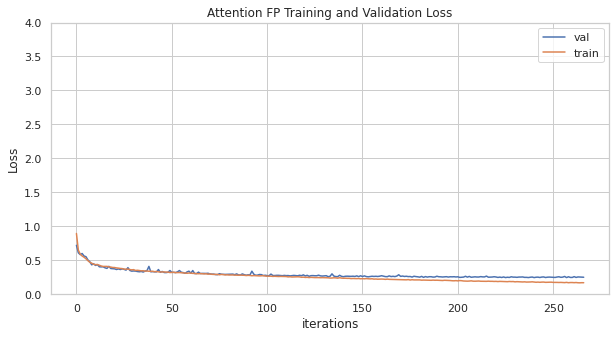

In [31]:
plt.figure(figsize=(10,5))
plt.title("Attention FP Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0, 4)
plt.savefig('AttentionTrainAndValidation.png', dpi=400,transparent=True)
plt.show()

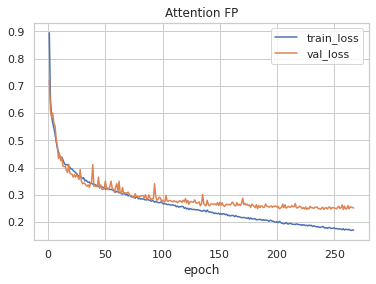

In [32]:
ax = plt.subplot(1,1,1)
ax.plot([e for e in range(1,len(train_losses) + 1)], train_losses, label="train_loss")
ax.plot([e for e in range(1,len(val_losses) + 1)], val_losses, label="val_loss")
plt.xlabel("epoch")
plt.title('Attention FP')
plt.grid(True)
plt.savefig('Attention FP Train.png', dpi=400,transparent=True)
ax.legend()

In [33]:
y_pred_arr = []
target_array = []
for data in test_loder:
    data = data.to(device)
    y_pred = model(data.x.float(), data.edge_index,data.batch)
    y_pred_arr.append(y_pred)
    target_array.append(data.y.float())

In [34]:
y_ped=torch.cat(y_pred_arr).view(-1).cpu().detach().numpy()
y_true=torch.cat(target_array).cpu().detach().numpy()

In [35]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import math

In [36]:
MSE = mean_squared_error(y_true, y_ped)
print(MSE)

0.12558185


In [37]:
#r2_score(y_true, y_pred)

In [38]:
mae = mean_absolute_error(y_true,y_ped)

In [39]:
print(mae)

0.24719694


In [40]:
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.3543752892642716


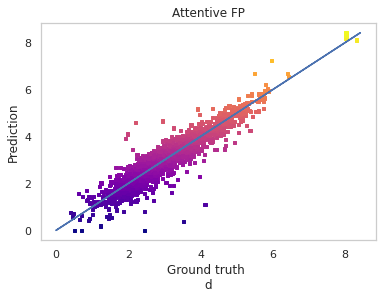

In [41]:
# plt.scatter(y_ped,y_true,s=10,marker ="s",c=y_true,cmap=plt.get_cmap('plasma'))
plt.scatter(y_ped,y_true,s=10,marker ="s",c=y_true,cmap=plt.get_cmap('plasma'))
plt.plot(y_true,y_true)
plt.xlabel('Ground truth \nd')
plt.ylabel('Prediction')
plt.title('Attentive FP')
plt.grid(False)
plt.savefig('Attention FP.png', dpi=400,transparent=True,bbox_inches = "tight")
plt.show()

# Train

In [42]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [43]:
smile = "OC(=O)Cc1c[nH]c2cc(ccc12)CC"

In [44]:
smile_graph = {}
band_gap_arr = []
smiles_array = []

g = gd.smile_to_graph(smile)
if g != None:
    smile_graph[smile] = g
    band_gap_arr.append(0.00)
    smiles_array.append(smile)

In [45]:
one_data = Molecule_data(root='data', dataset='one_data_set',y=band_gap_arr,smile_graph=smile_graph,smiles=smiles_array)

In [46]:
one_loder   = DataLoader(one_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)

In [47]:
next(iter(one_loder))

Batch(x=[15, 114], edge_index=[2, 32], y=[1], c_size=[1], batch=[15], ptr=[2])

In [48]:
for data in one_loder:
    data = data.to(device)
    y_pred = model(data.x.float(), data.edge_index,data.batch)
    print(y_pred)

tensor([[3.2338]], device='cuda:6', grad_fn=<AddmmBackward>)


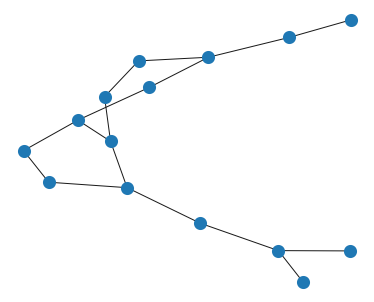

In [49]:
import networkx as nx
from torch_geometric import torch_geometric
for data in one_loder:
    data = data.to(device)
    gdata = torch_geometric.data.Data(x=data.x.float(), edge_index=data.edge_index)
    g = torch_geometric.utils.to_networkx(gdata, to_undirected=True)
    plt.figure(1,figsize=(5,4)) 
    nx.draw(g, cmap=plt.get_cmap('Set1'),node_size=50,linewidths=6)
#     plt.show()
#     nx.draw(g)
    break

#### 